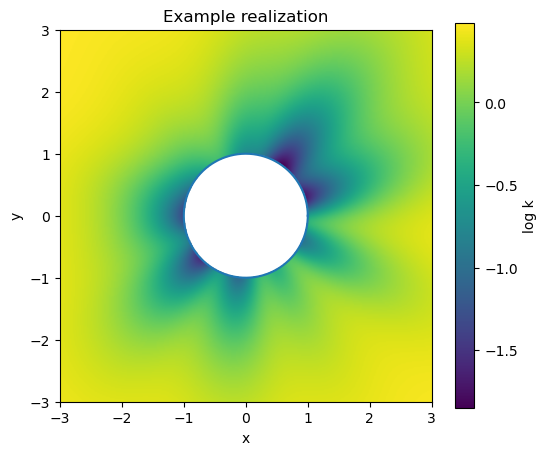

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tunnel_random_field as trf

rng = np.random.default_rng(2025)

# 1) Sample circle fields
theta, A_theta, lambda_theta = trf.sample_tunnel_circle_fields(
    ell_A=0.4, sigma_A_field=1.0, mu_A=-1.0, sigma_A=0.5,
    ell_lambda=1.5, sigma_lambda_field=1.0,
    n_modes_A=10, n_modes_lambda=10,
    rng=rng,
)

# 2) Build one 2D realization
log_k, x, y = trf.build_tunnel_logk_field(theta, A_theta, lambda_theta)

# 3) Plot it
fig, ax = plt.subplots(figsize=(6,5))
trf.plot_logk_field(log_k, x, y, title="Example realization", ax=ax)
plt.show()


Extracted 630 segments
((np.float64(1.13337326202395), np.float64(-0.158449212455671)), (np.float64(1.12551760826113), np.float64(-0.184122005844046)))
((np.float64(1.12551760826113), np.float64(-0.184122005844046)), (np.float64(1.12944543514254), np.float64(-0.171285609149859)))
((np.float64(1.13337326202395), np.float64(-0.158449212455671)), (np.float64(1.14122891578674), np.float64(-0.13277641906738)))
((np.float64(1.14122891578674), np.float64(-0.13277641906738)), (np.float64(1.13730108890534), np.float64(-0.145612815761526)))
((np.float64(1.12551760826113), np.float64(-0.184122005844046)), (np.float64(1.11766195449829), np.float64(-0.20979479923248)))


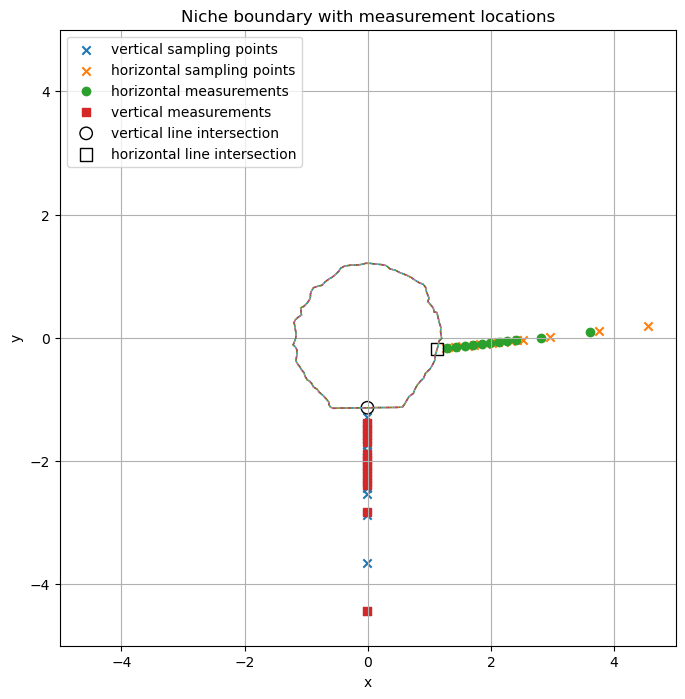

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import meshio
from typing import List, Tuple

Point = Tuple[float, float]
Segment = Tuple[Point, Point]


def load_niche_segments(filename: str) -> List[Segment]:
    mesh = meshio.read(filename)

    # Use only x,y (ignore z)
    points = mesh.points[:, :2]

    segments: List[Segment] = []

    for cell_block in mesh.cells:
        ctype = cell_block.type
        cells = cell_block.data

        # 2-node line elements
        if ctype in ("line", "line2"):
            for i0, i1 in cells:
                p0 = tuple(points[i0])
                p1 = tuple(points[i1])
                segments.append((p0, p1))

        # 3-node (quadratic) line elements: split into two linear segments
        elif ctype in ("line3",):
            for i0, i1, i2 in cells:
                p0, pm, p1 = points[[i0, i1, i2]]
                segments.append((tuple(p0), tuple(pm)))
                segments.append((tuple(pm), tuple(p1)))

        # Ignore other cell types (triangles, tets, etc.)
        else:
            continue

    return segments
# Niche boundary as small line segments (2D)
niche_segments = load_niche_segments("cd-a_niche4.vtu")
print(f"Extracted {len(niche_segments)} segments")
# Example: print first few
for seg in niche_segments[:5]:
    print(seg)

# For the full data, be sure to paste ALL lines of niche_segments
# from the assistant's answer without the "truncated" comment.


# Original sampling points along the two lines (already positioned w.r.t. niche)
orig_points_vertical = np.array(
    [
        [-0.00590468, -1.28667847],
        [-0.00589718, -1.43667847],
        [-0.00589218, -1.53667847],
        [-0.00588718, -1.63667847],
        [-0.00588218, -1.73667847],
        [-0.00587718, -1.83667847],
        [-0.00587218, -1.93667847],
        [-0.00586718, -2.03667847],
        [-0.00586218, -2.13667847],
        [-0.00585718, -2.23667847],
        [-0.00585218, -2.33667847],
        [-0.00584718, -2.43667847],
        [-0.00584218, -2.53667847],
        [-0.00582368, -2.87667847],
        [-0.00578568, -3.65667847],
        [-0.00574768, -4.43667847],
        [-0.00554868, -6.63667847],
        [-0.00554868, -6.63667847],
    ]
)

orig_points_horizontal = np.array(
    [
        [1.27414102, -0.16903214],
        [1.4231649, -0.15245487],
        [1.52251415, -0.14140337],
        [1.6218634, -0.13035186],
        [1.72121265, -0.11930035],
        [1.8205619, -0.10824884],
        [1.91991115, -0.09719733],
        [2.0192604, -0.08614582],
        [2.11860965, -0.07509431],
        [2.2179589, -0.0640428],
        [2.31730815, -0.05299129],
        [2.4166574, -0.04193978],
        [2.51600665, -0.03088827],
        [2.96220271, 0.01841753],
        [3.75690169, 0.10680927],
        [4.55160067, 0.19520102],
        [6.73710863, 0.4383037],
        [5.29653465, 0.27805686],
    ]
)

# Measurement depths [m] and permeabilities [m^2]
h_depths = np.array([0.17, 0.31, 0.45, 0.59, 0.73, 0.87, 1.01, 1.15, 1.29, 1.7, 2.5])
h_perm = np.array([5e-16, 2e-16, 2e-16, 2e-14, 5e-16,
                   8e-13, 3e-15, 8e-16, 4e-17, 2e-20, 5e-21])

v_depths = np.array([0.25, 0.35, 0.45, 0.55, 0.75, 0.85,
                     0.95, 1.05, 1.15, 1.25, 1.7, 3.3])
v_perm = np.array([2e-17, 8e-17, 8e-17, 8e-15, 7e-15, 4e-18,
                   6e-18, 2e-15, 7e-16, 9e-17, 5e-17, 8e-21])

# Intersection points of the lines with the niche boundary
p_vert = np.array([-0.00591218, -1.13667847])
p_horiz = np.array([1.12506055, -0.18561569])

# Direction vectors (unit) along each line, from boundary into rock
# These are the same as used to construct the measurement coordinates previously.
# Reconstruct them from two original points:
d_vert_unit = (orig_points_vertical.mean(axis=0) - p_vert)
d_vert_unit /= np.linalg.norm(d_vert_unit)

d_horiz_unit = (orig_points_horizontal.mean(axis=0) - p_horiz)
d_horiz_unit /= np.linalg.norm(d_horiz_unit)

# Corresponding coordinates of measurement locations along the two lines
# pos = p + depth * direction
h_coords = p_horiz + np.outer(h_depths, d_horiz_unit)
v_coords = p_vert + np.outer(v_depths, d_vert_unit)


def main():
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot niche boundary
    for (x0, y0), (x1, y1) in niche_segments:
        ax.plot([x0, x1], [y0, y1], linewidth=1.0)

    # Plot original sampling points
    ax.scatter(
        orig_points_vertical[:, 0],
        orig_points_vertical[:, 1],
        marker="x",
        label="vertical sampling points",
    )
    ax.scatter(
        orig_points_horizontal[:, 0],
        orig_points_horizontal[:, 1],
        marker="x",
        label="horizontal sampling points",
    )

    # Plot measurement locations (missing vertical values dropped already)
    ax.scatter(
        h_coords[:, 0], h_coords[:, 1],
        marker="o", label="horizontal measurements",
    )
    ax.scatter(
        v_coords[:, 0], v_coords[:, 1],
        marker="s", label="vertical measurements",
    )

    # Mark intersections with niche
    ax.scatter(
        [p_vert[0]], [p_vert[1]],
        s=80, facecolors="none", edgecolors="k",
        marker="o", label="vertical line intersection",
    )
    ax.scatter(
        [p_horiz[0]], [p_horiz[1]],
        s=80, facecolors="none", edgecolors="k",
        marker="s", label="horizontal line intersection",
    )

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Niche boundary with measurement locations")

    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.grid(True)
    ax.legend(loc="upper left")

    plt.show()



main()